# Perform full registration (rigid and chunked)

In [1]:
import sys
sys.path.insert(0, '..')
import pwreg
import torch
import torch.nn.functional as F
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

In [32]:
# Load dataset and downsample
X = pwreg.Dataset('../data/nissl_2.nii.gz', '../data/tau_2.nii.gz', '../data/nissl_chunk_mask_2.nii.gz', torch.float)

# Downsample the image and the mask
I_fix, I_mov, I_fmsk = X.I_fix.downsample(1/16.), X.I_mov.downsample(1/16.), X.M_fix.downsample(1/16.)

# Add a little noise
I_fix.T = I_fix.T + 0.001 * torch.normal(torch.zeros_like(I_fix.T), torch.ones_like(I_fix.T))
I_mov.T = I_mov.T + 0.001 * torch.normal(torch.zeros_like(I_mov.T), torch.ones_like(I_mov.T))

# Binarize the mask and apply dilation to pieces
Mnew = torch.zeros(I_fmsk.T.shape)
for j in range(I_fmsk.T.shape[0]):
      x = sitk.GetImageFromArray(I_fmsk.T[j,0,:,:].detach().numpy())
      x = sitk.BinaryThreshold(x, 0.5, 1e100, 1, 0)
      # x = sitk.BinaryDilate(x, [2, 2])
      Mnew[j,0,:,:] = torch.Tensor(sitk.GetArrayFromImage(x))

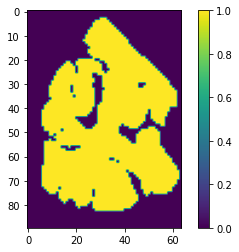

In [33]:
# Dilate the mask by NCC radius
#kernel = torch.ones((1,1,5,5))
#Mnew = F.conv2d(I_fmsk.T, kernel, padding=2)
#Mnew = F.threshold(-F.threshold(F.conv2d(I_fmsk.T, kernel, padding=2), 1.0, 0.0), -0.5, 1)
plt.imshow(torch.sum(Mnew,axis=0).squeeze())
plt.colorbar()

In [34]:
# Solve the registration problem with a single block mask
Mwhole = torch.where(torch.sum(Mnew,axis=0,keepdim=True) > 0.5, 1., 0.)
I_nomask = pwreg.Image2D(Mwhole, I_fmsk.ras)
R_nomask = pwreg.RigidProblem(I_fix, I_mov, I_nomask)

theta, dx, dy = pwreg.RigidProblemOptimizer.make_init_param(1, 0.0, 0.0, 0.0)
Q_init = R_nomask.apply_tform_to_moving(R_nomask.compute_tform(theta, dx, dy))

RO_nomask = pwreg.RigidProblemOptimizer(R_nomask, 0.0)
hist, ncc_val, ovl_val = RO_nomask.optimize(theta, dx, dy, 100)
Q_opt = R_nomask.apply_tform_to_moving(R_nomask.compute_tform(theta, dx, dy))

Iter 000 NCC:   0.0207, OVL:  -0.0079, OBJ:   0.9793, 
Iter 001 NCC:   0.0242, OVL:  -0.0152, OBJ:   0.9758, 
Iter 002 NCC:   0.0374, OVL:  -0.0146, OBJ:   0.9626, 
Iter 003 NCC:   0.0376, OVL:  -0.0143, OBJ:   0.9624, 
Iter 004 NCC:   0.0376, OVL:  -0.0143, OBJ:   0.9624, 
Iter 005 NCC:   0.0376, OVL:  -0.0143, OBJ:   0.9624, 
Iter 006 NCC:   0.0376, OVL:  -0.0143, OBJ:   0.9624, 
Iter 007 NCC:   0.0376, OVL:  -0.0143, OBJ:   0.9624, 
Iter 008 NCC:   0.0376, OVL:  -0.0143, OBJ:   0.9624, 
Iter 009 NCC:   0.0376, OVL:  -0.0143, OBJ:   0.9624, 
Iter 010 NCC:   0.0376, OVL:  -0.0143, OBJ:   0.9624, 
Iter 011 NCC:   0.0376, OVL:  -0.0143, OBJ:   0.9624, 
Iter 012 NCC:   0.0376, OVL:  -0.0143, OBJ:   0.9624, 
Iter 013 NCC:   0.0376, OVL:  -0.0143, OBJ:   0.9624, 
Iter 014 NCC:   0.0376, OVL:  -0.0143, OBJ:   0.9624, 
Iter 015 NCC:   0.0376, OVL:  -0.0143, OBJ:   0.9624, 
Iter 016 NCC:   0.0376, OVL:  -0.0143, OBJ:   0.9624, 
Iter 017 NCC:   0.0376, OVL:  -0.0143, OBJ:   0.9624, 
Iter 018 N

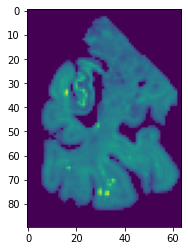

In [35]:
plt.imshow((Mwhole * I_fix.T)[0,0,:,:].detach())

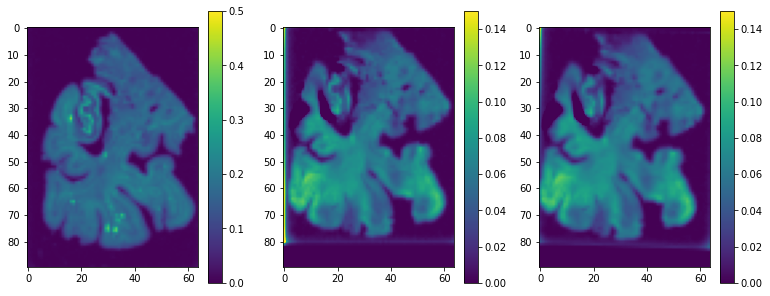

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 5), ncols=3);
fig.colorbar(ax1.imshow(R_nomask.I_fix.T.squeeze(), vmin=0, vmax=0.5), ax=ax1);
fig.colorbar(ax2.imshow(Q_init[0,0,:,:].detach(), vmin=0, vmax=0.15), ax=ax2);
fig.colorbar(ax3.imshow(Q_opt[0,0,:,:].detach(), vmin=0, vmax=0.15), ax=ax3);

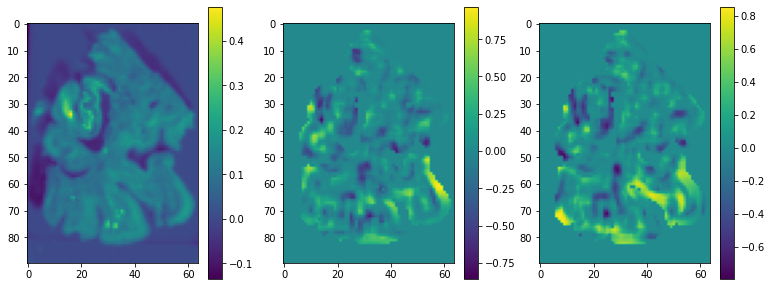

In [37]:
# Look at the NCC map
ncc_init = R_nomask.ncc.ncc_maps(I_fix.T, Q_init, Mwhole)
ncc_opt = R_nomask.ncc.ncc_maps(I_fix.T, Q_opt, Mwhole)
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 5), ncols=3);
fig.colorbar(ax1.imshow(R_nomask.I_fix.T.squeeze() - Q_opt.detach().squeeze()), ax=ax1);
fig.colorbar(ax2.imshow(ncc_init[0,:,:].squeeze().detach()), ax=ax2);
fig.colorbar(ax3.imshow(ncc_opt[0,:,:].squeeze().detach()), ax=ax3);

In [38]:
I_mov.T.shape

torch.Size([1, 1, 81, 70])

In [39]:
# Solve the registration problem with piecewise mask
I_chunkmask = pwreg.Image2D(Mnew, I_fmsk.ras)
I_chunk = pwreg.Image2D(I_fix.T.repeat(8,1,1,1), I_fix.ras)
R_chunk = pwreg.RigidProblem(I_chunk, I_mov, I_chunkmask)

theta2, dx2, dy2 = pwreg.RigidProblemOptimizer.make_init_param(8, theta.item(), dx.item(), dy.item())
Q_init = R_chunk.apply_tform_to_moving(R_chunk.compute_tform(theta2, dx2, dy2))

RO_chunk = pwreg.RigidProblemOptimizer(R_chunk, 0.001)
hist, ncc_val, ovl_val = RO_chunk.optimize(theta2, dx2, dy2, 100)
Q_opt = R_chunk.apply_tform_to_moving(R_chunk.compute_tform(theta2, dx2, dy2))
M_inv = R_chunk.ovl.overlap_image(torch.inverse(R_chunk.compute_tform(theta2, dx2, dy2)))

Iter 000 NCC:   0.0265, OVL:  -0.0143, OBJ:   7.7881, 
Iter 001 NCC:   0.0354, OVL:  -0.0055, OBJ:   7.7167, 
Iter 002 NCC:   0.0381, OVL:   0.0226, OBJ:   7.6951, 
Iter 003 NCC:   0.0483, OVL:   0.0183, OBJ:   7.6134, 
Iter 004 NCC:   0.0516, OVL:   0.0030, OBJ:   7.5869, 
Iter 005 NCC:   0.0541, OVL:  -0.0000, OBJ:   7.5673, 
Iter 006 NCC:   0.0592, OVL:   0.0250, OBJ:   7.5262, 
Iter 007 NCC:   0.0735, OVL:   0.0699, OBJ:   7.4123, 
Iter 008 NCC:   0.0748, OVL:   0.0749, OBJ:   7.4015, 
Iter 009 NCC:   0.0962, OVL:   0.0707, OBJ:   7.2308, 
Iter 010 NCC:   0.1036, OVL:   0.0731, OBJ:   7.1713, 
Iter 011 NCC:   0.1068, OVL:   0.0728, OBJ:   7.1460, 
Iter 012 NCC:   0.1078, OVL:   0.0745, OBJ:   7.1381, 
Iter 013 NCC:   0.1127, OVL:   0.0757, OBJ:   7.0983, 
Iter 014 NCC:   0.1134, OVL:   0.0743, OBJ:   7.0930, 
Iter 015 NCC:   0.1140, OVL:   0.0705, OBJ:   7.0881, 
Iter 016 NCC:   0.1141, OVL:   0.0704, OBJ:   7.0871, 
Iter 017 NCC:   0.1142, OVL:   0.0714, OBJ:   7.0865, 
Iter 018 N

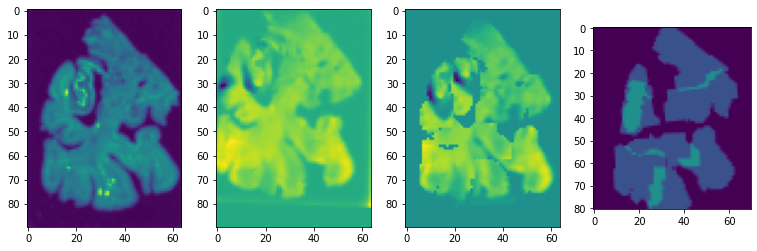

In [40]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(13, 4), ncols=4);
ax1.imshow(I_fix.T.squeeze(), aspect='equal')
ax2.imshow(Q_opt[4,0,:,:].detach(), aspect='equal')
ax3.imshow(torch.sum(Q_opt * R_chunk.M_fix.T, axis=0).squeeze().detach(), aspect='equal')
ax4.imshow(torch.sum(M_inv, axis=0).squeeze().detach(), vmin=0, vmax=4, aspect='equal')

In [11]:
ncc_val

tensor([0.3875, 0.3100, 0.3211, 0.3566, 0.3947, 0.3929, 0.3355, 0.3159],
       grad_fn=<DivBackward0>)

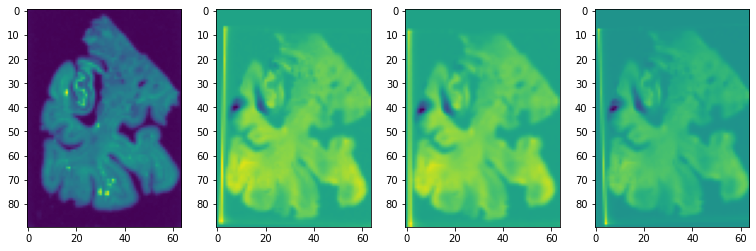

In [12]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(13, 4), ncols=4);
ax1.imshow(I_fix.T.squeeze(), aspect='equal')
ax2.imshow(Q_opt[1,0,:,:].detach(), aspect='equal')
ax3.imshow(Q_opt[2,0,:,:].detach(), aspect='equal')
ax4.imshow(Q_opt[4,0,:,:].detach(), aspect='equal')

In [30]:
kernel = pwreg.Image2D.gaussian_fft_kernel(R_chunk.I_fix.T, 3.0)
Msm = pwreg.Image2D.pytorch_gaussian_lpf(R_chunk.M_fix.T, 3.0, kernel)

In [52]:
A=R_chunk.compute_tform(theta2, dx2, dy2)
phi = torch.permute(
      F.affine_grid(A[:, 0:2, :], R_chunk.M_fix.T.shape, align_corners=False) -
      F.affine_grid(A[:, 0:2, :] * 0., R_chunk.M_fix.T.shape, align_corners=False), (0,3,1,2))
phi_sm = pwreg.Image2D.pytorch_gaussian_lpf(phi * R_chunk.M_fix.T, 3.0, kernel)

In [62]:
phi_test = torch.mean(phi_sm, axis=0) / (0.000001 + torch.mean(Msm, axis=0))

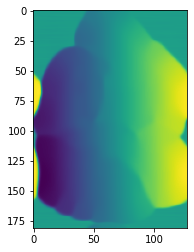

In [74]:
plt.imshow(phi_test[1,:,:].detach())

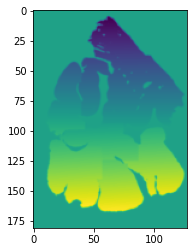

In [73]:
plt.imshow(torch.sum(phi * R_chunk.M_fix.T, axis=0)[1,:,:].detach())

In [66]:
Q_test = F.grid_sample(R_chunk.I_mov.T, phi_test.permute(1,2,0).unsqueeze(0), align_corners=False)

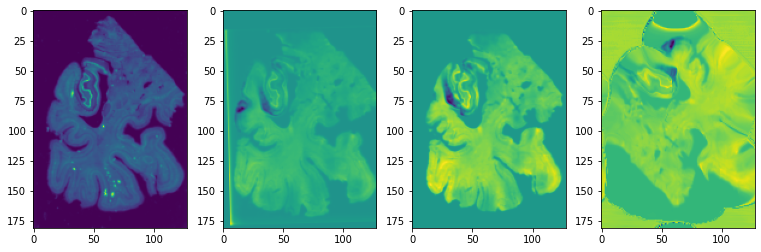

In [68]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(13, 4), ncols=4);
ax1.imshow(R_chunk.I_fix.T.squeeze(), aspect='equal')
ax2.imshow(Q_opt[4,0,:,:].detach(), aspect='equal')
ax3.imshow(torch.sum(Q_opt * R_chunk.M_fix.T, axis=0).squeeze().detach(), aspect='equal')
ax4.imshow(Q_test.squeeze().detach(), aspect='equal')

In [69]:
phi_test.permute(1,2,0).unsqueeze(0).shape

torch.Size([1, 181, 128, 2])